In [315]:
from src.mitnanex import run
import pandas as pd

In [316]:

a = run()

# I need to plot the coverage of clusters
coverages_df = pd.DataFrame(
    {
        "coverage": [i.coverage for i in a.clusters],
        "longest_read_len": [i.longest_read_length for i in a.clusters],
        "id_longest_read": [i.longest_read_id for i in a.clusters],
        "id_cluster":[i.id_cluster for i in a.clusters],
    }
)



In [317]:
# Test on the first 30 clusters
prueba = coverages_df.sort_values(by='coverage', ascending=False)
#prueba.sort_values(by='id_longest_read',inplace=True)
prueba = prueba[prueba['coverage']>10]
#prueba = prueba.head(50)
prueba

,coverage,longest_read_len,id_longest_read,id_cluster
1,134,27018,SRR5892449.8389,2
25,123,38792,SRR5892449.27537,26
7,112,35773,SRR5892449.18969,8
54,51,25209,SRR5892449.46373,55
47,49,22951,SRR5892449.22576,48
8,45,29533,SRR5892449.13231,9
13,42,28027,SRR5892449.37390,14
44,19,16946,SRR5892449.32857,45
107,15,15245,SRR5892449.30556,108
186,15,28094,SRR5892449.35075,187


# Oligo composition

Once I've detected the clusters with higher coverage, which I expect includes mitochondria and contamination, whether nuclear or external, I have to purify these groups. To do this I will use the oligo composition as it is used during metagenomics binning.

I will create a script to get the kmers. The kmer size will be 3 to solve two things: 1. Intrinsec error from Nanopore, 2 smaller set as possible (4**3 possible kmers). 

Finally, I will reduce dimensionality using PCA

In [318]:
from src.utils import get_sequences_by_id, convert_fq_to_fa
from src.kmer_cnt import count_kmer

In [319]:
#convert_fq_to_fa('test/s_cervisae_CEN.PK113-7D_SRR5892449_reads_sample.sorted.fastq','test/s_cervisae_CEN.PK113-7D_SRR5892449_reads_sample.sorted.fasta')

In [320]:
with open('test/s_cervisae_CEN.PK113-7D.fasta', 'r') as handle:
    s_cervisae = "".join(handle.read().splitlines()[1:-1])

In [321]:
fasta = 'test/s_cervisae_CEN.PK113-7D_SRR5892449_reads_sample.sorted.fasta'
repr_reads = [i for i in prueba['id_longest_read']]
hist = list()
for i in get_sequences_by_id(fasta, repr_reads):
    ids, seq = i
    hist.append([*count_kmer(k=3,seq=seq).values(),ids])

In [322]:
## Get the read mt sequences
with open('test/list_ids_reads_mt.txt','r') as handle_ids_mt:
    ids_mt = handle_ids_mt.read().splitlines()
    ids_mt = [i[1:] for i in ids_mt]

In [323]:
hist_df= pd.DataFrame(hist).sort_values(by=32)
hist_df['mt']=(hist_df[32].isin(ids_mt).astype(int) + 1) ** 5
hist_df.shape

(13, 34)

# Dimensionality reduction with PCA and clustering with k-means 

In [324]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [325]:
pca = PCA(n_components=2)
pca.fit(hist_df.iloc[:,:-2])

PCA(n_components=2)

In [326]:
# Components and variance explained 
pca.explained_variance_
#pca.components_

array([1.27407640e-02, 7.96395114e-05])

In [327]:
kmer_reduction = pca.fit_transform(hist_df.iloc[:,:-2])
kmer_reduction = pd.DataFrame(kmer_reduction)
kmer_reduction['coverage'] = prueba['coverage'].values
kmer_reduction

,0,1,coverage
0,0.124693,-0.007172,134
1,0.128665,-0.000888,123
2,0.149227,-0.010529,112
3,0.100739,0.008346,51
4,-0.100697,-0.001295,49
5,0.137324,-0.003938,45
6,-0.104058,-0.000090,42
7,-0.089180,0.001089,19
8,-0.098547,-0.001203,15
9,-0.099952,-0.001570,15


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


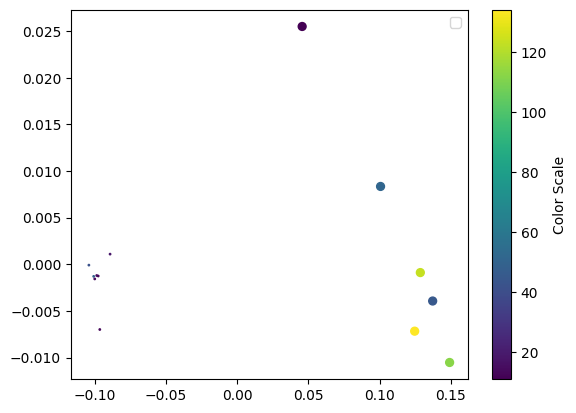

In [328]:
sc = plt.scatter(kmer_reduction[0],kmer_reduction[1], c=prueba['coverage'], s=hist_df['mt'])
# legend
# Add a colorbar
cbar = plt.colorbar(sc)
cbar.set_label('Color Scale')
plt.legend()

Initialization complete
Iteration 0, inertia 3539.107577690042.
Iteration 1, inertia 2850.1834626546497.
Converged at iteration 1: strict convergence.


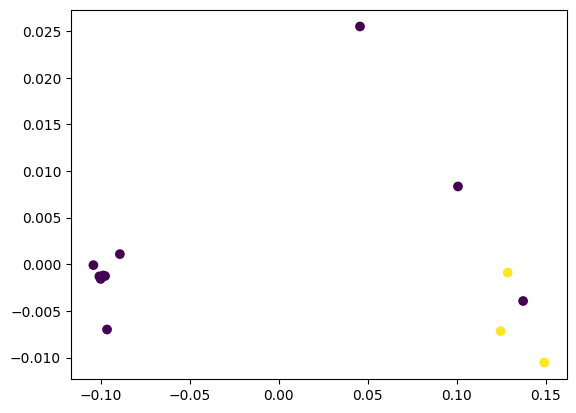

In [336]:
kmeans = KMeans(n_clusters=2, max_iter=100, init='k-means++', random_state=0, n_init=1,verbose=1)
kmer_reduction.rename(columns={0:'comp0',1:'comp1'}, inplace=True)
prediction = kmeans.fit_predict(kmer_reduction)
plt.scatter(x=kmer_reduction['comp0'], y=kmer_reduction['comp1'], c=prediction)
